In [1]:
import jax
import jax.numpy as jnp


def constraint(y):
    x1, x2 = y
    c1 = x1 - x2
    c2 = x1**2 + x2**2 - 1
    c3 = x1 - 3
    return jnp.array([c1, c2]), jnp.array(c3)


y0 = jnp.ones(2)

equality_hessians, inequality_hessians = jax.hessian(constraint)(y0)

equality_hessians.shape

duals = (jnp.ones(2), jnp.ones(1))

jnp.ones((1, 1)).size, jnp.ones((1,)).size, jnp.ones(()).size

(1, 1, 1)

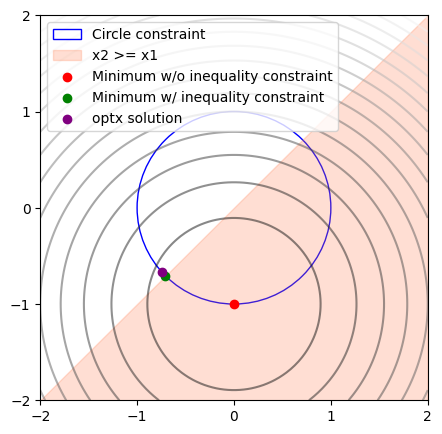

In [2]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optimistix as optx


jax.config.update("jax_enable_x64", True)


def objective(y, args):
    del args
    x1, x2 = y
    return x1**2 + (x2 + 1) ** 2  # Minimize the sum of squares


def constraint(y):
    x1, x2 = y
    c1 = x1**2 + x2**2 - 1  # Circle constraint
    c2 = x2 - x1  # x2 >= 1
    return c1, c2


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

x = jnp.linspace(-2, 2, 100)
y = jnp.linspace(-2, 2, 100)
X, Y = jnp.meshgrid(x, y)


def wrapped_objective(y):
    return objective(y, None)


Z = wrapped_objective((X, Y))

ax.contour(X, Y, Z, levels=20, alpha=0.5, cmap="Grays_r")

circle = plt.Circle((0, 0), 1, color="blue", fill=False, label="Circle constraint")
ax.add_patch(circle)

labels = [-2, -1, 0, 1, 2]
ax.set_xticks(labels)
ax.set_yticks(labels)

ax.fill_between(x, x, -2, color="coral", alpha=0.25, label="x2 >= x1")

ax.scatter(0, -1, color="red", label="Minimum w/o inequality constraint")
ax.scatter(-0.707, -0.707, color="green", label="Minimum w/ inequality constraint")
ax.scatter(*[-0.7475722, -0.66417936], color="purple", label="optx solution")
ax.legend()

In [3]:
solver = optx.IPOPTLike(rtol=1e-4, atol=1e-8)
descent = optx.XDYcYdDescent()
solver = eqx.tree_at(lambda x: x.descent, solver, descent)


solution = optx.minimise(
    objective,
    solver,
    jnp.array([-0.1, -0.0]),  # Start from inequality constrained optimum
    constraint=constraint,
    max_steps=25,
    throw=False,
)

solution.value

Array([-0.74791306, -0.66379565], dtype=float64)

We seem to converge to a "wrong spot" - perhaps to be expected with a hard-coded, nonadaptive barrier parameter I still have in the solver?

In [4]:
jnp.stack(jnp.eye(2)).shape

(2, 2)

In [5]:
# https://github.com/Tim-Salzmann/l4casadi/blob/main/examples/fish_turbulent_flow/README.md